  # Logistic Regression Classifier

## Goal
- Build a **logistic regression classifier** to recognize images of cats.
- Approach the problem with a **neural network mindset**:
  - Think in terms of forward propagation, cost functions, gradients, and optimization.
  - Even though logistic regression is simple, the workflow mirrors how deeper models are trained.

---

## Key Concepts
- **Forward propagation**: compute activations using weights and bias.
- **Cost function**: measure how far predictions are from true labels (binary cross-entropy).
- **Backward propagation**: compute gradients of cost w.r.t. parameters.
- **Gradient descent**: update parameters iteratively to minimize cost.

---

## Workflow
1. **Import packages**  
   - `numpy` → numerical computations, vectorized operations.  
   - `matplotlib` → plotting and visualization.  
   - `h5py` → load dataset stored in HDF5 format.  
   - `PIL` & `scipy` → test model with custom images.  
   - `lr_utils` → helper function to load cat/non-cat dataset.

We also enable `%matplotlib inline` so plots appear directly in the notebook.

2. **Load dataset**  
   - Training set: `(209, 64, 64, 3)` images, labels `(1, 209)`.  
   - Test set: `(50, 64, 64, 3)` images, labels `(1, 50)`.  
   - Classes: `[b'non-cat', b'cat']`.

3. **Preprocess data**  
   - Flatten images: reshape `(m, 64, 64, 3)` → `(12288, m)`.  
   - Normalize pixel values: divide by 255 to scale into `[0,1]`.

4. **Model building**  
   - Initialize parameters: `w` zeros `(12288,1)`, `b=0`.  
   - Implement `sigmoid` activation.  
   - Implement `propagate()` for forward + backward pass.  
   - Implement `optimize()` for gradient descent.  
   - Wrap everything into `model()`.

---

## Notes
- **Indexing**: labels are `(1, m)`, so always use `[0, i]`.  
- **Predictions**: may be floats (0.0/1.0). Convert to `int()` before indexing into `classes`.  
- **Cost printing**: use `print_cost=True` to monitor training every 100 iterations.  
- **Normalization**: critical for convergence — don’t skip dividing by 255.  
- **Shapes sanity check**:  
  - `X`: `(12288, m)`  
  - `Y`: `(1, m)`  
  - `w`: `(12288, 1)`  
  - `b`: scalar  

---

## Big Picture
- Logistic regression here is a **single-layer neural network**:
  - Input → linear combination → sigmoid → output probability.
- This assignment builds intuition for deeper networks:
  - Same steps (init → forward → cost → backward → update).
- Scaling up: hidden layers just add more weight matrices and activations, but the logic stays the same.


In [77]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset

%matplotlib inline

# 📂 Loading the Data (Cat vs Non-Cat)

## What happens here
- We call `load_dataset()` from **lr_utils.py**.
- This function reads the training and test sets from HDF5 files:
  - `train_catvnoncat.h5`
  - `test_catvnoncat.h5`
- It returns **five objects**:
  1. `train_set_x_orig` → training images, shape `(m_train, 64, 64, 3)`
  2. `train_set_y` → training labels, shape `(1, m_train)`
  3. `test_set_x_orig` → test images, shape `(m_test, 64, 64, 3)`
  4. `test_set_y` → test labels, shape `(1, m_test)`
  5. `classes` → array of class names `[b'non-cat', b'cat']`

---

## Shapes to remember
- **Training set:**
  - `train_set_x_orig.shape = (209, 64, 64, 3)`
  - `train_set_y.shape = (1, 209)`
- **Test set:**
  - `test_set_x_orig.shape = (50, 64, 64, 3)`
  - `test_set_y.shape = (1, 50)`
- **Classes:**
  - `classes = [b'non-cat', b'cat']`  
  - Use `.decode("utf-8")` to convert from bytes → string (`"non-cat"`, `"cat"`).

---

## Notes
- Each image is **64 × 64 pixels × 3 channels (RGB)** → total features per image = **12288**.
- Labels are stored as **row vectors** `(1, m)` → always index with `[0, i]`.
- The dataset is small (209 train, 50 test) → good for learning, but not for production.
- This step is just **loading raw data**; preprocessing (flattening + normalization) comes next.


In [78]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [79]:
import os
print(os.listdir("datasets"))


['test_catvnoncat.h5', 'train_catvnoncat.h5']


# 🔎 Checking Dataset Shapes

## Code
```python
print(train_set_x_orig.shape, train_set_y.shape, test_set_x_orig.shape, test_set_y.shape)
```
---
## Output (expected)
- train_set_x_orig.shape = (209, 64, 64, 3)
- train_set_y.shape = (1, 209)
- test_set_x_orig.shape = (50, 64, 64, 3)
- test_set_y.shape = (1, 50)
---
## Notes to Self
- **Training set images:**
    - 209 examples
    - Each image is 64 × 64 pixels with 3 channels (RGB).
    - Shape (209, 64, 64, 3) → first dimension is number of examples, the rest are image dimensions.
- **Training labels:**
    - Shape (1, 209) → one row, 209 columns.
    - Each entry is 0 (non-cat) or 1 (cat).
    - Important: always index with [0, i] to get the label for image i.
- **Test set images:**
    - 50 examples, same image size.
    - Shape (50, 64, 64, 3).
- **Test labels:**
    - Shape (1, 50) → one row, 50 columns.
    - Same indexing rule as training labels.

In [80]:
print(train_set_x_orig.shape, train_set_y.shape, test_set_x_orig.shape, test_set_y.shape)

(209, 64, 64, 3) (1, 209) (50, 64, 64, 3) (1, 50)


# 🖼️ Visualizing an Example Image

## Code
```python
index = 10
plt.imshow(train_set_x_orig[index])   # show image at position 10
plt.title(f"Label: {train_set_y[0, index]} ({classes[train_set_y[0, index]].decode('utf-8')})")
plt.axis('off')
plt.show()
```
---
## What this does
- **Selects an image**: train_set_x_orig[index] → the 10th training image.
- **Displays the image**: plt.imshow(...) renders the RGB image.
- **Adds a title**: shows both the numeric label (0 or 1) and the decoded class name ("non-cat" or "cat").
- **Removes axes**: plt.axis('off') hides pixel coordinate ticks for a cleaner view.
---
## Notes to Self
- **Indexing rule**:
    - **Images**: train_set_x_orig[index] → shape (64, 64, 3).
    - **Labels**: train_set_y[0, index] → scalar 0 or 1.
    - **Classes**: classes[...] → byte string (b'cat' or b'non-cat'), decode to normal string.
- **Decoded labels**:
    - `0 → "non-cat"`
    - `1 → "cat"`
- **Why visualize**:
    - Sanity check that images and labels match.
    - Helps confirm dataset integrity before training.
    - Useful for debugging misclassifications later.
---
## Example output
- Image of a cat or non-cat.
- Title: Label: 1 (cat) or Label: 0 (non-cat) depending on the chosen index.

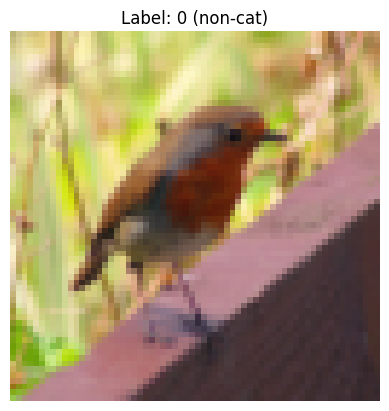

In [81]:
index = 10
plt.imshow(train_set_x_orig[index])
plt.title(f"Label: {train_set_y[0, index]} ({classes[train_set_y[0, index]].decode('utf-8')})")
plt.axis('off')
plt.show()


# 🖼️ Example of a Picture (with Label)

## Code
```python
index = 15
plt.imshow(train_set_x_orig[index])   # show image at position 15
print("y = " + str(train_set_y[0, index]) +
      ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +
      "' picture.")
```
---
## What this does
- **Selects an image**: train_set_x_orig[index] → the 15th training image.
- **Displays the image**: plt.imshow(...) renders the RGB image.
- **Prints the label**:
    - `train_set_y[0, index]` → numeric label (0 or 1).
    - `np.squeeze(train_set_y[:, index])` → removes extra dimensions, ensuring a clean scalar.
    - `classes[...]` → maps numeric label to class name (b'non-cat' or b'cat').
    - `.decode("utf-8")` → converts byte string to normal string ("non-cat" or "cat").
---
## Notes to Self
- Why use `np.squeeze`:
    - Labels are stored as `(1, m)` arrays.
    - `np.squeeze(train_set_y[:, index])` ensures you get a scalar (not a 1D array).
    - This avoids shape issues when indexing into `classes`.
- Decoded labels:
    - `0 → "non-cat"`
    - `1 → "cat"`
- Output format:
    - Example: `y = 0, it's a 'non-cat' picture.`
    - Example: `y = 1, it's a 'cat' picture.`
---
## Why this step matters
- Confirms that labels and images align correctly.
- Helps you visually inspect the dataset and verify that preprocessing hasn’t corrupted the data.
- Useful for debugging later when predictions don’t match true labels.

y = 0, it's a 'non-cat' picture.


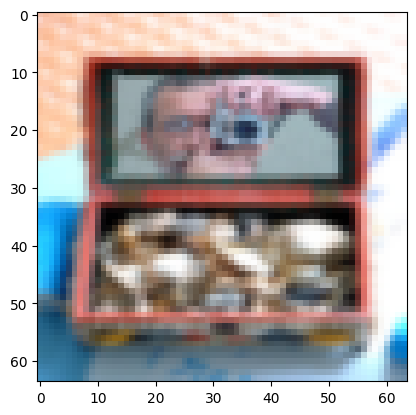

In [82]:
# Example of a picture
index =15
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[0, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

# 📊 Dataset Statistics

## Code
```python
m_train = train_set_x_orig.shape[0]   # number of training examples
m_test = test_set_x_orig.shape[0]     # number of test examples
num_px = train_set_x_orig.shape[1]    # height/width of each image

print("Number of training examples: m_train =", m_train)
print("Number of testing examples: m_test =", m_test)
print("Height/Width of each image: num_px =", num_px)
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_set_x shape:", train_set_x_orig.shape)
print("train_set_y shape:", train_set_y.shape)
print("test_set_x shape:", test_set_x_orig.shape)
print("test_set_y shape:", test_set_y.shape)
```
---
## Expected Output
- Number of training examples: **209**
- Number of testing examples: **50**
- Height/Width of each image: **64**
- Each image is of size: `(64, 64, 3)`
- Shapes:
    - `train_set_x_orig.shape = (209, 64, 64, 3)`
    - `train_set_y.shape = (1, 209)`
    - `test_set_x_orig.shape = (50, 64, 64, 3)`
    - `test_set_y.shape = (1, 50)`
---
## Notes to Self
- m_train = 209 → total training images.
- m_test = 50 → total test images.
- num_px = 64 → each image is 64 × 64 pixels.
- Image size = (64, 64, 3) → 3 channels (RGB).
- Flattened feature size = 64 × 64 × 3 = 12288 → this is the dimensionality of the input vector for logistic regression.
- Labels are stored as (1, m) arrays → always index with [0, i].
---
## Why this matters
- These statistics define the input size of the model.
- The weight vector w in logistic regression must have shape (12288, 1) to match the flattened image size.
- Knowing m_train and m_test helps when computing accuracy and cost functions (since they average over m).
- This step ensures the dataset is correctly structured before preprocessing (flattening + normalization).

In [83]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test =  test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


# 🔄 Reshaping (Flattening) the Training and Test Examples

## Code
```python
train_set_x_flatten = train_set_x_orig.reshape(
    train_set_x_orig.shape[1] * train_set_x_orig.shape[2] * train_set_x_orig.shape[3],
    train_set_x_orig.shape[0]
)
test_set_x_flatten = test_set_x_orig.reshape(
    test_set_x_orig.shape[1] * test_set_x_orig.shape[2] * test_set_x_orig.shape[3],
    test_set_x_orig.shape[0]
)

print("train_set_x_flatten shape:", train_set_x_flatten.shape)
print("train_set_y shape:", train_set_y.shape)
print("test_set_x_flatten shape:", test_set_x_flatten.shape)
print("test_set_y shape:", test_set_y.shape)
print("sanity check after reshaping:", train_set_x_flatten[0:5, 0])
```
---
## Expected Output
- `train_set_x_flatten.shape = (12288, 209)`
- `train_set_y.shape = (1, 209)`
- `test_set_x_flatten.shape = (12288, 50)`
- `test_set_y.shape = (1, 50)`
- Sanity check: prints the first 5 pixel values of the first training image.
---
## Notes to Self
- Why flatten?
    - Original images: `(m, 64, 64, 3)` → 4D array.
    - Logistic regression expects feature vectors, not 2D images.
    - Flattening converts each image into a column vector of size 12288 (64 × 64 × 3).
- Resulting shapes:
    - Training set: `(12288, 209)` → 12288 features per image, 209 examples.
    - Test set: `(12288, 50)` → 12288 features per image, 50 examples.
    - Labels remain `(1, m)` → one row, m columns.
- Sanity check:
    - `train_set_x_flatten[0:5, 0]` → first 5 pixel values of the first image.
    - Confirms reshaping worked correctly.
---
## Why this matters
- Flattening ensures compatibility with matrix operations in forward propagation:
- `𝑤𝑇𝑋 + 𝑏` requires X to be `(n_features, m)`.
- This step transforms raw image data into the numerical format required for machine learning.
- Without flattening, logistic regression cannot process the images.

In [84]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 2 lines of code)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[1]*train_set_x_orig.shape[2]*train_set_x_orig.shape[3],train_set_x_orig.shape[0])
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[1]*test_set_x_orig.shape[2]*test_set_x_orig.shape[3],test_set_x_orig.shape[0])
### END CODE HERE ###

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 71 49 38 70]


---
# ⚖️ Normalizing the Dataset

## Code
```python
train_set_x = train_set_x_flatten / 255.
test_set_x = test_set_x_flatten / 255.
```
---
## What this does
- **Pixel values** in images are originally integers in the range `[0, 255]` (since RGB channels store values from 0 = black to 255 = full intensity).
- Dividing by `255.` scales all values into the range `[0, 1]`.
- This normalization is applied to both training and test sets.
---
## Notes to Self
- Why normalize?
    - Prevents large input values from destabilizing gradient descent.
    - Speeds up convergence during optimization.
    - Ensures all features (pixels) are on the same scale.
- Resulting shapes remain the same:
    - `train_set_x.shape = (12288, 209)`
    - `test_set_x.shape = (12288, 50)`
- Values after normalization:
    - Each pixel intensity is now a float between 0 and 1.
    - Example: a pixel value of 128 becomes `128/255 ≈ 0.502`.
---
## Why this matters
- Logistic regression (and most ML algorithms) work best when inputs are small and standardized.
- Normalization improves numerical stability and helps avoid issues like exploding gradients.
- This step is always required when working with image data.

In [85]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

---
# ➕ Sigmoid Activation Function

## Code
```python
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1 / (1 + np.exp(-z))
    return s

print("sigmoid([0, 2]) =", sigmoid(np.array([0, 2])))
```
---
## What this does
- Defines the sigmoid function:
$$\sigma(z) = \frac{1}{1 + e^{-z}}$$
- Works for:
    - A single scalar (`z` is one number).
    - A NumPy array (`z` is a vector or matrix).
- Returns values in the range (0, 1).
---
## Notes to Self
- Purpose in logistic regression:
    - Converts raw scores (logits) into probabilities.
    - Example: if $ 𝑧 = 𝑤^𝑇𝑥 + 𝑏,$ then `𝜎(𝑧)` is the probability that the label is 1 (cat).
- Properties:
    - `𝜎(0) = 0.5` → neutral probability.
    - As 𝑧 → +∞, 𝜎(𝑧) → 1.
    - As 𝑧 → −∞, 𝜎(𝑧) → 0.
- Derivative (important for backpropagation):
    $$𝜎′(𝑧) = 𝜎(𝑧)⋅(1−𝜎(𝑧))$$
---
## Example Output
- `sigmoid([0, 2]) = [0.5, 0.88079708]`
    - For `z = 0` → probability = 0.5.
    - For `z = 2` → probability ≈ 0.88 (strong confidence towards class 1).
---
## Why this matters
- Sigmoid is the link function between linear algebra (dot products) and probability.
- It ensures predictions are interpretable as probabilities.
- This is the core of logistic regression:

    $$𝑦^ = 𝜎(𝑤^𝑇𝑥+𝑏)$$

In [86]:
# FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1/(1+np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [87]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


---
# ⚙️ Initializing Parameters (w and b)

## Code
```python
def initialize_with_zeros(dim):
    """
    Creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector (number of features)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (bias)
    """
    w = np.zeros((dim, 1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

dim = 2
w, b = initialize_with_zeros(dim)
print("w =", w)
print("b =", b)
```
---
## What this does
- Creates weight vector `w`:
    - Shape `(dim, 1)` → one weight per feature.
    - Initialized to all zeros.
- Creates bias `b`:
    - Scalar value.
    - Initialized to 0.
- Assertions:
    - Ensure w has correct shape.
    - Ensure b is a number (float or int).
---
## Notes to Self
- Why initialize with zeros?
    - Logistic regression is convex → starting at zeros is fine.
    - Gradient descent will update weights correctly.
- Shape reminder:
    - For cat dataset, `dim = 12288` (flattened image size).
    - So `w.shape = (12288, 1)`.
- Bias `b`:
    - Just a scalar shift in the decision boundary.
- Example test:
    - With `dim = 2`, output is:
        - `w = [[0.], [0.]]`
        - `b = 0`
---
## Why this matters
- Initialization is the first step in training.
- Ensures parameters are defined before forward/backward propagation.
- In deeper networks, initialization strategies matter more (e.g., Xavier, He initialization).
- For logistic regression, zeros are sufficient because symmetry is broken by the data itself

In [88]:
# FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((dim,1))
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [89]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


---
## Function purpose
`propagate(w, b, X, Y)` computes:
- **Forward pass:** activations and cost.
- **Backward pass:** gradients w.r.t. `w` and `b`.

Returns:
- `cost` → scalar loss
- `dw` → gradient same shape as `w` \((n, 1)\)
- `db` → scalar gradient

---

## Shapes and conventions
- `X`: \((n, m)\) where \(n = 64 * 64 * 3 = 12288\), \(m\) = number of examples.
- `w`: \((n, 1)\), `b`: scalar.
- `Y`: \((1, m)\).
- `A`: \((1, m)\) after sigmoid.

---

## Forward pass
- Linear:
  

$$
  Z = w^T X + b \quad \text{(shape } (1, m)\text{)}
  $$


- Activation:
  

$$
  A = \sigma(Z) = \frac{1}{1 + e^{-Z}}
  $$


- Cost (binary cross-entropy, averaged over \(m\)):
  

$$
  J = \frac{1}{m}\sum_{i=1}^{m} \left[-Y_i \log(A_i) - (1 - Y_i)\log(1 - A_i)\right]
  $$



---

## Backward pass (gradients)
Let \(E = A - Y\) with shape \((1, m)\).
- Gradient w.r.t. weights:
  

$$
  \mathrm{d}w = \frac{1}{m} X E^T \quad \text{(shape } (n, 1)\text{)}
  $$


- Gradient w.r.t. bias:
  

$$
  \mathrm{d}b = \frac{1}{m} \sum_{i=1}^{m} E_i \quad \text{(scalar)}
  $$



These are fully vectorized (no loops).

---

## Code recap
- `A = sigmoid(np.dot(w.T, X) + b)` computes activations.
- `cost = np.sum(-np.log(A)*Y - np.log(1-A)*(1-Y)) / m` computes average loss.
- `dw = np.dot(X, (A - Y).T) / m` and `db = np.sum(A - Y) / m` compute gradients.

---

## Notes to self
- Ensure `w` and `X` align: `w.T` is \((1, n)\) and `X` is \((n, m)\).
- Use `np.squeeze(cost)` so `cost` becomes a scalar.
- For numerical stability, consider clipping `A`:
  

$$
  A = \mathrm{clip}(A,\ \epsilon,\ 1-\epsilon) \quad \text{with } \epsilon \approx 10^{-15}
  $$


- Assertions help catch shape/type errors early.


In [90]:
# FUNCTION: propagate
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T,X) + b)              # compute activation
    cost = np.sum(((- np.log(A))*Y + (-np.log(1-A))*(1-Y)))/m  # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = (np.dot(X,(A-Y).T))/m
    db = (np.sum(A-Y))/m
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [91]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


---
# 🔄 Optimization with Gradient Descent

## Function: `optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False)`

### Purpose
- Runs **gradient descent** to optimize parameters \(w\) and \(b\).
- Iteratively:
  1. Compute cost and gradients using `propagate()`.
  2. Update parameters with gradient descent rule.
- Returns:
  - `params` → dictionary containing updated `w` and `b`.
  - `grads` → dictionary containing final gradients `dw` and `db`.
  - `costs` → list of costs recorded every 100 iterations (used for plotting learning curve).

---

## Forward + Backward Recap
- Forward pass: compute activations and cost.
- Backward pass: compute gradients.
- Gradient descent update rules:
  

$$
  w := w - \alpha \cdot dw
  $$


  

$$
  b := b - \alpha \cdot db
  $$


  where $\alpha$ = learning rate.

---

## Key Details
- **`num_iterations`**: number of gradient descent steps.
- **`learning_rate`**: step size for updates.
- **`print_cost`**: optional flag to monitor cost every 100 iterations.
- **`costs` list**: stores cost values at checkpoints → useful for plotting convergence.

---

## Example Run
```python
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print("w =", params["w"])
print("b =", params["b"])
print("dw =", grads["dw"])
print("db =", grads["db"])
```
---
## Expected Behavior
- `w` and `b` move away from zero towards values that minimize cost.
- `dw` and `db` represent the final gradients after last iteration.
- `costs` contains ~1 value (since 100 iterations, cost recorded only at iteration 0).
---
## Notes to Self
- Learning rate choice:
    - Too small → slow convergence.
    - Too large → may overshoot and fail to converge.
- Cost monitoring:
    - Printing every 100 iterations helps check if cost is decreasing.
    - Plotting `costs` later shows the learning curve.
- Convexity:
    - Logistic regression cost function is convex → gradient descent guaranteed to find global minimum.
-Practical tip:
    -Always check shapes of `dw` and `db` to avoid broadcasting errors.


In [92]:

# FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w - (learning_rate*dw)
        b = b - (learning_rate*db)
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [93]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


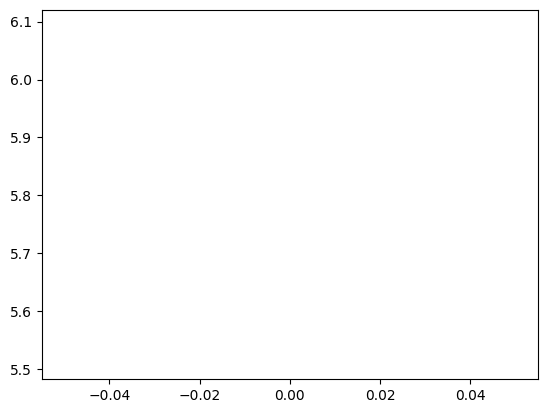

In [94]:
plt.plot(costs)

---
# 🔮 Prediction Function

## Function: `predict(w, b, X)`

### Purpose
- Uses learned parameters \(w, b\) to predict labels for input data \(X\).
- Returns a vector `Y_prediction` containing **0 (non-cat)** or **1 (cat)** for each example.

---

## Steps inside the function
1. **Setup**
   - `m = X.shape[1]` → number of examples.
   - Initialize `Y_prediction` as zeros with shape `(1, m)`.

2. **Compute probabilities**
   - Linear step: \( Z = w^T X + b \).
   - Activation: \( A = \sigma(Z) \).
   - Shape of `A`: `(1, m)` → one probability per example.

3. **Convert probabilities to predictions**
   - Threshold rule: if \( A_i \geq 0.5 \) → predict 1 (cat), else 0 (non-cat).
   - Implementations:
     - **If/Else loop** (explicit).
     - **One-line loop** (ternary operator).
     - **Vectorized implementation** (preferred):  
       ```python
       Y_prediction = (A >= 0.5) * 1.0
       ```
       This directly converts probabilities into 0/1 values without loops.

4. **Assertions**
   - Ensure `Y_prediction.shape == (1, m)`.

---

## Mathematical intuition
- Prediction rule:
  

$$
  \hat{y} =
  \begin{cases}
  1 & \text{if } \sigma(w^T x + b) \geq 0.5 \\
  0 & \text{otherwise}
  \end{cases}
  $$



- The sigmoid output is a probability.  
- Threshold at 0.5 → classify into one of two categories.

---

## Example Run
```python
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1., -1.1, -3.2],
              [1.2,  2.,   0.1]])
print("predictions =", predict(w, b, X))
```
---
## Expected Output
`predictions = [[1. 1. 0.]]`
---
## Notes to Self
- **Vectorization** is always preferred → faster and cleaner than loops.
- Predictions are floats (0.0 or 1.0) → but effectively represent binary labels.
- Always check shapes: `(1, m)` ensures compatibility with labels `Y`.
- This function is the **final step** in logistic regression: turning probabilities into actual class predictions.


In [95]:
# FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T,X) + b)           # Dimentions = (1, m)
    ### END CODE HERE ###
    
    #### WORKING SOLUTION 1: USING IF ELSE #### 
    #for i in range(A.shape[1]):
        ## Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        #if (A[0,i] >= 0.5):
        #    Y_prediction[0, i] = 1
        #else:
        #    Y_prediction[0, i] = 0
        ### END CODE HERE ###
        
    #### WORKING SOLUTION 2: ONE LINE ####
    #for i in range(A.shape[1]):
        ## Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        #Y_prediction[0, i] = 1 if A[0,i] >=0.5 else 0
        ### END CODE HERE ###
    
    #### WORKING SOLUTION 3: VECTORISED IMPLEMENTATION ####
    Y_prediction = (A >= 0.5) * 1.0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [96]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


---
# 🧩 Full Logistic Regression Model

## Function: `model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False)`
---
### Purpose
- Builds the **logistic regression classifier** end-to-end:
  1. Initialize parameters (`w`, `b`).
  2. Run optimization (gradient descent).
  3. Retrieve learned parameters.
  4. Make predictions on train and test sets.
  5. Report accuracy.
  6. Return all useful information in a dictionary.

---

## Workflow
1. **Initialize parameters**
   - `w, b = initialize_with_zeros(X_train.shape[0])`
   - For cat dataset: `w.shape = (12288, 1)`, `b = 0`.

2. **Optimize**
   - `parameters, grads, costs = optimize(...)`
   - Runs gradient descent for `num_iterations`.
   - Updates `w` and `b` using learning rate.

3. **Retrieve parameters**
   - Extract final `w` and `b` from `parameters`.

4. **Predict**
   - `Y_prediction_train = predict(w, b, X_train)`
   - `Y_prediction_test = predict(w, b, X_test)`
   - Predictions are binary (0 = non-cat, 1 = cat).

5. **Accuracy**
   - Train accuracy:
     

$$
     100 - \text{mean}(|Y_{\text{pred}} - Y_{\text{true}}|) \times 100
     $$


   - Test accuracy: same formula on test set.
   - Prints results for quick evaluation.

6. **Return dictionary**
   - Contains:
     - `costs`: list of costs recorded during training.
     - `Y_prediction_train`: predictions on training set.
     - `Y_prediction_test`: predictions on test set.
     - `w`, `b`: learned parameters.
     - `learning_rate`, `num_iterations`: hyperparameters.

---

## Example Run
```python
d = model(train_set_x, train_set_y, test_set_x, test_set_y,
          num_iterations=2000, learning_rate=0.005, print_cost=False)
```
---
## Expected Output
- Prints train and test accuracy (e.g., ~99% train, ~70% test).
- Returns dictionary `d` with all model details.

## Notes to Self
- Learning rate:
    - Critical hyperparameter → too high overshoots, too low converges slowly.
    - Typical values: 0.001 – 0.01 for this dataset.
- Iterations:
    - More iterations → better convergence, but slower.
    - 2000 is a good balance for small datasets.
- Accuracy gap:
    - Train accuracy usually higher than test accuracy.
    - Gap indicates overfitting if too large.
- Dictionary `d`:
    - Useful for plotting cost curve (`d["costs"]`).
    - Can inspect predictions (`d["Y_prediction_test"]`).
    - Stores hyperparameters for reproducibility.
---
## Big Picture
- This `model()` function is the master function:
    - Calls all helper functions (`initialize_with_zeros`, `propagate`, `optimize`, `predict`).
    - Produces a trained logistic regression classifier.
- Mirrors the workflow of deeper neural networks:
    - **Initialize → Forward → Cost → Backward → Update → Predict → Evaluate**.


In [97]:
# FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [98]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = False)

train accuracy: 91.38755980861244 %
test accuracy: 34.0 %


---
# ❌ Example of a Misclassified Picture

## Code
```python
index = 25
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
prediction = int(d["Y_prediction_test"][0, index])
print("y = " + str(test_set_y[0, index]) +
      ", you predicted that it is a \"" +
      classes[prediction].decode("utf-8") + "\" picture.")
```
## What this does
- **Selects a test image**: `test_set_x[:, index]` → the 25th test example.
- **Reshapes it back**: `(num_px, num_px, 3)` → converts flattened vector into original image shape.
- Displays the image: `plt.imshow(...)`.
- Prediction vs. truth:
    - `test_set_y[0, index]` → true label (0 = non-cat, 1 = cat).
    - `d["Y_prediction_test"][0, index]` → model’s predicted label.
    - Prints both side by side for comparison.
---
## Notes to Self
- **Why reshape?**
    - Test set was flattened into `(12288, m_test)`.
    - Must reshape back into `(64, 64, 3)` to visualize properly.
- Prediction decoding:
    - `classes[prediction].decode("utf-8")` → converts numeric prediction into `"cat"` or `"non-cat"` string.
- Output format:
    - Example:
     `y = 0, you predicted that it is a "cat" picture`.
    - Shows mismatch between true label and prediction.
---

## Why this matters
- Misclassified examples highlight limitations of logistic regression:
    - Simple linear decision boundary may not capture complex patterns in images.
    - Cats vs. non-cats can be tricky when images are noisy, unusual, or ambiguous.
- Inspecting errors helps:
    - Understand dataset challenges.
    - Motivate the need for deeper models (multi-layer neural networks).
    - Provide intuition about bias/variance trade-offs.
---
## Big Picture
- Logistic regression is a baseline model.
- Misclassifications are expected, especially on small datasets.
- This step is crucial for error analysis → the foundation of improving models in deep learning.

y = 1, you predicted that it is a "non-cat" picture.


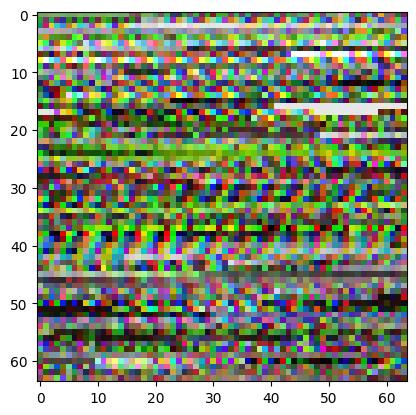

In [99]:
# Example of a picture that was wrongly classified.
index = 25
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
prediction = int(d["Y_prediction_test"][0, index])
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + classes[prediction].decode("utf-8") +  "\" picture.")

---
# 📉 Plotting the Learning Curve

## Code
```python
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()
```
---
## What this does
- Extracts costs: `d['costs']` contains the cost values recorded every 100 iterations during optimization.
- Removes extra dimensions: `np.squeeze(...)` ensures `costs` is a 1D array for plotting.
- Plots the curve:
    - X-axis → iteration count (per hundreds).
    - Y-axis → cost value.
    - Title shows the learning rate used.
---
## Notes to Self
- **Interpretation**:
    - Curve should **decrease over time** → indicates gradient descent is minimizing cost.
    - If curve is flat → learning rate too small.
    - If curve oscillates/diverges → learning rate too large.
- **Shape of curve**:
    - Typically exponential decay → sharp drop at first, then gradual flattening.
- **Debugging tip**:
    - Always check cost decreases steadily.
    - If not, adjust `learning_rate` or increase `num_iterations`.
---
## Why this matters
- Visual confirmation that training is working.
- Helps tune hyperparameters:
    - **Learning rate** → affects slope of curve.
    - **Iterations** → affects how far curve progresses.
- Essential for diagnosing convergence issues in optimization.

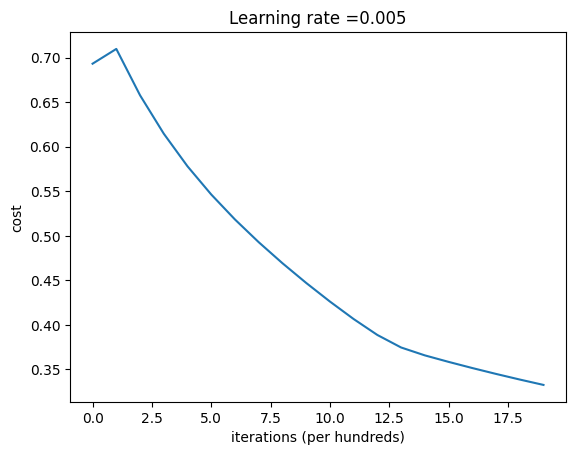

In [100]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

---
# ⚖️ Comparing Different Learning Rates

## Code
```python
learning_rates = [0.01, 0.001, 0.0001]
models = {}

# Train models with different learning rates
for i in learning_rates:
    print("learning rate is:", i)
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y,
                           num_iterations=1500, learning_rate=i, print_cost=False)
    print("\n-------------------------------------------------------\n")

# Plot cost curves for each learning rate
for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label=str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')
legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()
```
---
## What this does
- Trains multiple models:
    - Each with a different learning rate (`0.01`, `0.001`, `0.0001`).
    - Runs gradient descent for 1500 iterations.
- Stores results in `models` dictionary.
- Plots cost curves:
    - X-axis → iterations (per hundreds).
    - Y-axis → cost.
    - Each curve corresponds to a different learning rate.
---
## Notes to Self
- **Learning rate impact**:
    - **Too high (e.g., 0.01)** → cost may decrease quickly but risk overshooting or oscillating.
    - **Moderate (e.g., 0.001)** → smoother convergence, often a good balance.
    - **Too low (e.g., 0.0001)** → very slow convergence, cost decreases minimally.
- **Cost curve analysis**:
    - Steeper drop = faster learning.
    - Smooth curve = stable learning.
    - Flat curve = learning rate too small.
- **Best practice**:
    - Always experiment with multiple learning rates.
    - Plot curves to visually confirm convergence behavior.
---
## Why this matters
- Learning rate is the most important hyperparameter in gradient descent.
- Determines speed and stability of convergence.
- Comparing curves helps select the optimal learning rate for the dataset.
- This experiment shows how sensitive logistic regression is to learning rate choice.

learning rate is: 0.01
train accuracy: 71.29186602870814 %
test accuracy: 34.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 74.16267942583733 %
test accuracy: 34.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 66.02870813397129 %
test accuracy: 34.0 %

-------------------------------------------------------



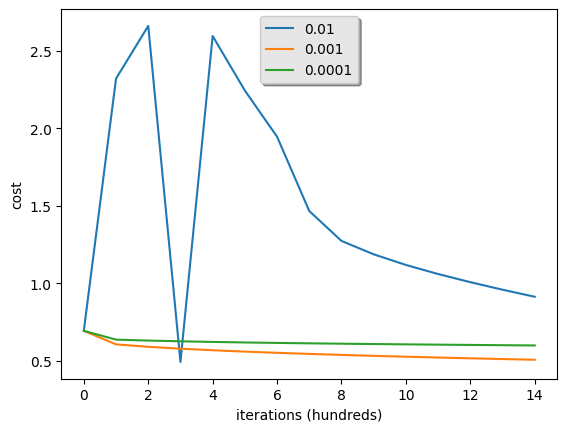

In [101]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()